### CNN

In [26]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:

REBUILD_DATA = True # set to true to one once, then back to false unless you want to change something in your training data.

class DogsVSCats():
    IMG_SIZE = 50
    CATS = "PetImages/Cat"
    DOGS = "PetImages/Dog"
    TESTING = "PetImages/Testing"
    LABELS = {CATS: 0, DOGS: 1}
    training_data = []

    catcount = 0
    dogcount = 0

    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                if "jpg" in f:
                    try:
                        path = os.path.join(label, f)
                        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                        img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                        label_one_hot = np.eye(2)[self.LABELS[label]]
                        self.training_data.append((img, label_one_hot))

                        if label == self.CATS:
                            self.catcount += 1
                        elif label == self.DOGS:
                            self.dogcount += 1

                    except Exception as e:
                        pass
                        #print(label, f, str(e))

        np.random.shuffle(self.training_data)

        # Convert the list of tuples to a structured numpy array
        training_data_array = np.array(self.training_data, dtype=object)
        np.save("training_data.npy", training_data_array)

        print('Cats:', self.catcount)
        print('Dogs:', self.dogcount)

if REBUILD_DATA:
    dogsvcats = DogsVSCats()
    dogsvcats.make_training_data()


PetImages/Cat


100%|██████████| 12501/12501 [00:12<00:00, 987.65it/s] 


PetImages/Dog


100%|██████████| 12501/12501 [00:11<00:00, 1111.73it/s]


Cats: 12476
Dogs: 12470


In [3]:
training_data = np.load("training_data.npy", allow_pickle=True)
print(len(training_data))

24946


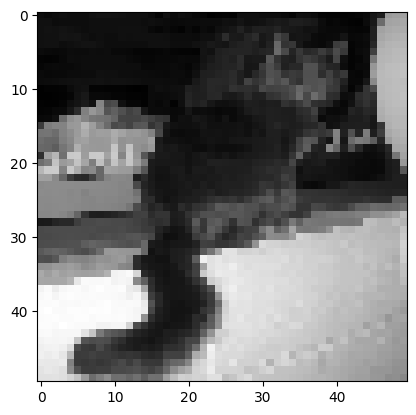

In [4]:
import matplotlib.pyplot as plt
plt.imshow(training_data[1][0], cmap="gray")
plt.show()

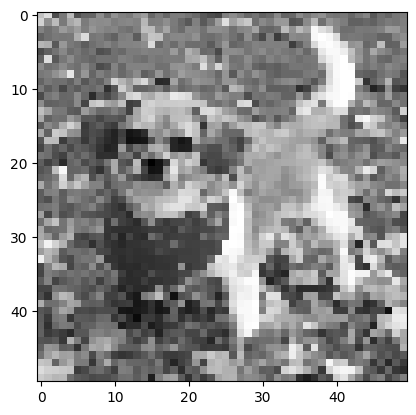

In [5]:
import matplotlib.pyplot as plt
plt.imshow(training_data[2][0], cmap="gray")
plt.show()

In [22]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on gpu")
else:
    device = torch.device("cpu")
    print("Running on cpu")

Running on gpu


In [31]:

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)  # 5x5 kernel
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)

        x = torch.randn(50, 50).view(-1, 1, 50, 50)
        self._to_linear = None
        self.convs(x)

        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512, 2)
    
    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))

        if self._to_linear is None:
            self._to_linear = x[0].shape[0] * x[0].shape[1] * x[0].shape[2]
        return x
    
    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        # Apply softmax outside the model if needed, or change to log_softmax if using CrossEntropyLoss
        return F.softmax(x, dim=1)

# Example usage
net = Net().to(device)

import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr= 0.001)
loss_function = nn.MSELoss()

X = torch.Tensor([i[0] for i in training_data]).view(-1, 50, 50)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1
val_size = int(len(X)*VAL_PCT)
print(val_size)

train_x = X[:-val_size]
train_y = y[:-val_size]

test_x = X[-val_size:]
test_y = y[-val_size:]

print(len(train_x))
print(len(test_x))

BATCH_SIZE = 100
EPOCHS = 10

def train(net):
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    loss_function = nn.MSELoss()
    for epoch in range(EPOCHS):
        epoch_loss = 0
        for i in tqdm(range(0, len(train_x), BATCH_SIZE)):
            batch_x = train_x[i:i+BATCH_SIZE].view(-1, 1, 50, 50)
            batch_y = train_y[i:i+BATCH_SIZE]

            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
    
            net.zero_grad()
            outputs = net(batch_x)
            loss = loss_function(outputs, batch_y)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        # Display the loss after the epoch is completed
        print(f"Epoch {epoch + 1}/{EPOCHS}, Loss: {epoch_loss:.6f}")


def test(net):
    correct = 0
    total = 0

    with torch.no_grad():
        for i in tqdm(range(len(test_x))):
            real_class = torch.argmax(test_y[i]).to(device)
            net_out = net(test_x[i].view(-1,1,50,50).to(device))[0]
            predicted_class = torch.argmax(net_out)
            if predicted_class ==  real_class:
                correct += 1
            total += 1
    print("Accuracy : ", round(correct/total*100, 3))

train(net)
test(net)

2494
22452
2494


100%|██████████| 225/225 [00:04<00:00, 50.29it/s]


Epoch 1/10, Loss: 52.045815


100%|██████████| 225/225 [00:04<00:00, 54.00it/s]


Epoch 2/10, Loss: 44.093803


100%|██████████| 225/225 [00:03<00:00, 56.34it/s]


Epoch 3/10, Loss: 38.952366


100%|██████████| 225/225 [00:04<00:00, 54.29it/s]


Epoch 4/10, Loss: 35.285024


100%|██████████| 225/225 [00:03<00:00, 56.54it/s]


Epoch 5/10, Loss: 31.794436


100%|██████████| 225/225 [00:03<00:00, 57.36it/s]


Epoch 6/10, Loss: 29.336265


100%|██████████| 225/225 [00:04<00:00, 54.79it/s]


Epoch 7/10, Loss: 26.786916


100%|██████████| 225/225 [00:03<00:00, 57.22it/s]


Epoch 8/10, Loss: 24.369520


100%|██████████| 225/225 [00:03<00:00, 56.93it/s]


Epoch 9/10, Loss: 23.052081


100%|██████████| 225/225 [00:04<00:00, 54.05it/s]


Epoch 10/10, Loss: 22.500305


100%|██████████| 2494/2494 [00:02<00:00, 1224.98it/s]

Accuracy :  75.301
